# GIK Character Prediction Model

Train a model to predict keyboard characters from IMU sensor data.


In [88]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
import yaml
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path
PROJECT_ROOT = os.path.dirname(os.path.abspath('__file__'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from pretraining import preprocess_multiple_sources, load_preprocessed_dataset, export_dataset_to_csv, get_class_weights
from src.Constants.char_to_key import INDEX_TO_CHAR, CHAR_TO_INDEX, NUM_CLASSES
from src.pre_processing.reduce_dim import reduce_dim
from src.visualisation.visualisation import (
    compute_confusion_matrix_40x40,
    plot_confusion_matrix_40x40,
    plot_anchor_with_closest_neighbours,
    plot_virtual_keyboard_heatmap,
    show_predictions as viz_show_predictions,
    show_predictions_coordinate as viz_show_predictions_coordinate,
)
from ml.models.gik_model import create_model_auto_input_dim, GIKTrainer, decode_predictions
from ml.models.loss_functions.custom_losses import FocalLoss, CoordinateLoss, CoordinateLossClassification

torch.manual_seed(42)
np.random.seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"PyTorch {torch.__version__} | Device: {DEVICE}")

PyTorch 2.10.0 | Device: mps


## Configuration

In [89]:
from src.Constants.char_to_key import (
    KEY_COORDS,
    SPECIAL_COORDS,
    SPACE_ANCHORS,
    ALL_CHARS,
    FULL_COORDS,
)

print(f"Loaded keyboard coordinate constants for {len(ALL_CHARS)} classes")

Loaded keyboard coordinate constants for 40 classes


In [90]:
# Load experiment config from project-root YAML
CONFIG_PATH = os.path.join(PROJECT_ROOT, "train_config.yaml")
with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config_data = yaml.safe_load(f)

# Data paths (paired keyboard + IMU files)
DATA_DIR = config_data["data"]["data_dir"]
KEYBOARD_FILES = config_data["data"]["keyboard_files"]
LEFT_FILES = config_data["data"].get("left_files")
RIGHT_FILES = config_data["data"].get("right_files")
PROCESSED_DATA_PATH = os.path.join(DATA_DIR, "processed_dataset.pt")

# Build CONFIG from shared + mode-specific sections
EXPERIMENT = config_data["experiment"]
MODE = EXPERIMENT["mode"]
MODE_CONFIG = config_data["modes"][MODE]

CONFIG = {
    "max_seq_length": EXPERIMENT["max_seq_length"],
    "reduce_dim": EXPERIMENT["use_dim_reduction"],
    "dim_red_method": EXPERIMENT.get("dim_red_method", "pca"),
    "dim_red_dims_ratio": EXPERIMENT.get("dim_red_dims_ratio", 0.4),
    "enable_class_weights": MODE_CONFIG.get("use_class_weights", False),
    "run_preprocess": EXPERIMENT["run_preprocess"],
    "export_dataset_csv": EXPERIMENT["export_dataset_csv"],
    **config_data["model"],
    **config_data["train"],
    **MODE_CONFIG,
}

# Resolve object references encoded as strings in YAML
KEY_MAPPING_REGISTRY = {
    "FULL_COORDS": FULL_COORDS,
    "CHAR_TO_INDEX": CHAR_TO_INDEX,
}
LOSS_REGISTRY = {
    "CoordinateLossClassification": CoordinateLossClassification,
    "CoordinateLoss": CoordinateLoss,
    "FocalLoss": FocalLoss,
}
OUTPUT_LOGITS_REGISTRY = {
    "NUM_CLASSES": NUM_CLASSES,
}

CONFIG["key_mapping_dict"] = KEY_MAPPING_REGISTRY[CONFIG["key_mapping_dict"]]
CONFIG["loss"] = LOSS_REGISTRY[CONFIG["loss"]]
if isinstance(CONFIG["output_logits"], str):
    CONFIG["output_logits"] = OUTPUT_LOGITS_REGISTRY[CONFIG["output_logits"]]

print(f"Loaded config: {CONFIG_PATH}")
print(f"Mode: {MODE}")
print(f"Data dir: {DATA_DIR}")
print(f"Keyboard files: {KEYBOARD_FILES}")
print(f"Left IMU files: {LEFT_FILES}")
print(f"Right IMU files: {RIGHT_FILES}")
print(f"Model: {CONFIG['model_type']}")
print(f"Seq length: {CONFIG['max_seq_length']}")
print(f"Loss: {CONFIG['loss'].__name__}")
print(f"Run preprocess: {CONFIG['run_preprocess']}")
print(f"Export CSV: {CONFIG['export_dataset_csv']}")
print(f"Dim red: {CONFIG['reduce_dim']} | method: {CONFIG['dim_red_method']}")
print(f"Use class weights: {CONFIG['enable_class_weights']}")

Loaded config: /Users/souparna/perceptron-gik/train_config.yaml
Mode: classification
Data dir: data_jun_3
Keyboard files: ['Keyboard_13.csv']
Left IMU files: ['Left_13.csv']
Right IMU files: None
Model: attention_lstm
Seq length: 10
Loss: FocalLoss
Run preprocess: False
Export CSV: False


## Preprocess Data

In [91]:
if CONFIG["run_preprocess"]:
    # Preprocess and combine multiple data sources
    metadata = preprocess_multiple_sources(
        data_dir=DATA_DIR,
        keyboard_files=KEYBOARD_FILES,
        left_files=LEFT_FILES,
        right_files=RIGHT_FILES,
        output_path=PROCESSED_DATA_PATH,
        max_seq_length=CONFIG['max_seq_length'],
        normalize=True,
        apply_filtering=True
    )
else:
    # Assume preprocessing already done and .pt file exists
    preprocessed = torch.load(PROCESSED_DATA_PATH, weights_only=False)
    metadata = preprocessed["metadata"]
    print(f"Using existing preprocessed dataset: {PROCESSED_DATA_PATH}")

Using existing preprocessed dataset: data_jun_3/processed_dataset.pt


In [92]:
print(f"\nTotal Samples: {metadata['num_samples']} | Feat dim: {metadata['feat_dim']} | Sources: {metadata['num_sources']}")


Total Samples: 2289 | Feat dim: 59 | Sources: 1


In [93]:
if CONFIG["run_preprocess"] and CONFIG["export_dataset_csv"]:
    # Export to CSV for inspection (optional)
    export_dataset_to_csv(PROCESSED_DATA_PATH, DATA_DIR, include_features=True)

## Dimensionality Reduction

In [ ]:
if CONFIG["reduce_dim"]:
    DIM_RED_OUTPUT = os.path.join(DATA_DIR, "dim_red_output.pt")

    payload = torch.load(PROCESSED_DATA_PATH, weights_only=False)
    metadata = payload.get("metadata", {})
    has_left = metadata.get("has_left", False)
    has_right = metadata.get("has_right", True)

    reduce_kwargs = {
        "data_dir": PROCESSED_DATA_PATH,
        "method": CONFIG.get("dim_red_method", "pca"),
        "has_left": has_left,
        "has_right": has_right,
        "normalise": True,
        "output_path": DIM_RED_OUTPUT,
    }
    if reduce_kwargs["method"] == "pca":
        reduce_kwargs["dims_ratio"] = CONFIG.get("dim_red_dims_ratio", 0.4)

    dims = reduce_dim(**reduce_kwargs)

    print(
        f"Feature dimension reduced from {dims['dim_bef']} to {dims['dim_aft']} "
        f"using {reduce_kwargs['method']}"
    )

Feature dimension reduced from 59 to 23


## Balance DataSet

In [95]:
if CONFIG["enable_class_weights"]:
    class_weights = get_class_weights(DIM_RED_OUTPUT if CONFIG["reduce_dim"] else PROCESSED_DATA_PATH)
    # class_weights.to(DEVICE)
    if CONFIG["loss"] == FocalLoss:
        CONFIG["loss_params"]["alpha"] = class_weights
    elif CONFIG["loss"] == CoordinateLossClassification:
        CONFIG["loss_params"]["class_weights"] = class_weights

## Load Dataset & Create Model

In [96]:
dataset = load_preprocessed_dataset(DIM_RED_OUTPUT if CONFIG["reduce_dim"] else PROCESSED_DATA_PATH, 
                                    is_one_hot_labels=CONFIG["is_one_hot"],
                                    char_to_index=CONFIG["key_mapping_dict"],
                                    return_class_id=CONFIG["return_class_id"])
print(f"Dataset: {len(dataset)} samples | Input dim: {dataset.input_dim}")

# Create model
model = create_model_auto_input_dim(
    dataset,
    model_type=CONFIG['model_type'],
    hidden_dim_inner_model=CONFIG['hidden_dim_inner_model'],
    hidden_dim_classification_head=CONFIG['hidden_dim_classification_head'],
    no_layers_classification_head=CONFIG['num_layers'],
    dropout_inner_layers=CONFIG['dropout'],
    inner_model_kwargs=CONFIG['inner_model_prams'],
    output_logits = CONFIG['output_logits'],
)

# Print model architecture
print("\n" + "=" * 60)
print("Model architecture")
print("=" * 60)
print(model)
print("=" * 60)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Dataset: 2289 samples | Input dim: 63

Model architecture
GIKModelWrapper(
  (input_projection): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (inner_model): AttentionLSTM(
    (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=256, out_features=128, bias=True)
  )
  (project_from_inner): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (fc_stack): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2)

## Train Model

In [97]:
trainer = GIKTrainer(
    model=model,
    dataset=dataset,
    batch_size=CONFIG['batch_size'],
    learning_rate=CONFIG['learning_rate'],
    device=DEVICE,
    loss=CONFIG.get('loss'),
    loss_kwargs=CONFIG.get('loss_params'),
    regression=CONFIG.get('regression'),
)

history = trainer.train(
    epochs=CONFIG['epochs'],
    early_stopping_patience=CONFIG['early_stopping']
)

Training on mps
Train: 1831, Val: 228, Test: 230 (causal split, no shuffle)
------------------------------------------------------------
Epoch   1/300 
Train Loss: 3.0339 | Val Loss: 2.6172 
Train Acc: 0.1496 | Val Acc: 0.2588 
  -> Saved best model (val_loss: 2.6172)
Epoch   2/300 
Train Loss: 2.7749 | Val Loss: 2.3906 
Train Acc: 0.2103 | Val Acc: 0.2588 
  -> Saved best model (val_loss: 2.3906)
Epoch   3/300 
Train Loss: 2.5760 | Val Loss: 2.2164 
Train Acc: 0.1983 | Val Acc: 0.2588 
  -> Saved best model (val_loss: 2.2164)
Epoch   4/300 
Train Loss: 2.4334 | Val Loss: 2.0424 
Train Acc: 0.2157 | Val Acc: 0.2588 
  -> Saved best model (val_loss: 2.0424)
Epoch   5/300 
Train Loss: 2.3202 | Val Loss: 1.8916 
Train Acc: 0.2157 | Val Acc: 0.3246 
  -> Saved best model (val_loss: 1.8916)
Epoch   6/300 
Train Loss: 2.2040 | Val Loss: 1.7875 
Train Acc: 0.2348 | Val Acc: 0.3377 
  -> Saved best model (val_loss: 1.7875)
Epoch   7/300 
Train Loss: 2.1271 | Val Loss: 1.7276 
Train Acc: 0.2578

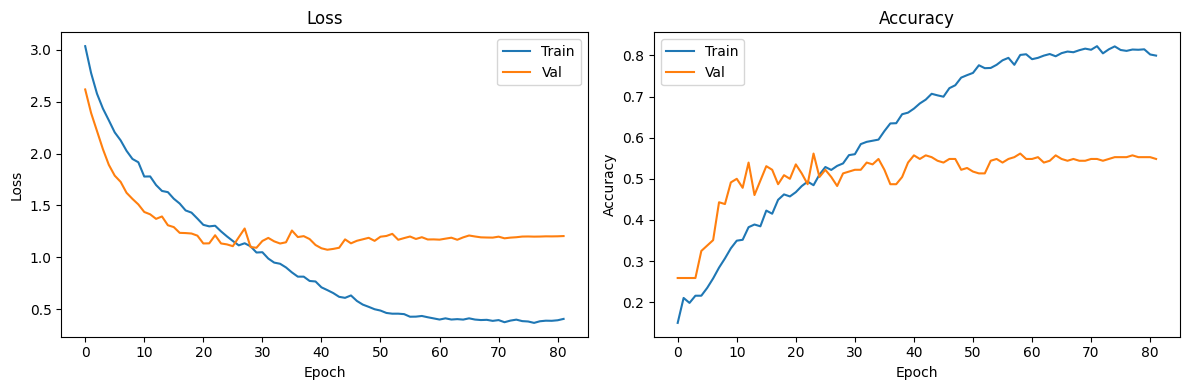

In [98]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')


axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Accuracy')

plt.tight_layout()
plt.show()

## Evaluate Model

In [99]:
# Evaluate on validation set
val_loss, val_acc = trainer.validate()
print(f"Validation Loss: {val_loss:.4f}")  
# print("Validation Accuracy: {val_acc:.2%}")
print()

# Evaluate on test set
test_loss, test_acc = trainer.evaluate_test()
print(f"Test Loss: {test_loss:.4f}") 
# print(" Test Accuracy: {test_acc:.2%}")

Validation Loss: 1.2058

Test Loss: 1.2486


In [102]:
# Show validation predictions
if CONFIG["regression"]:
    viz_show_predictions_coordinate(trainer.val_dataset, model, DEVICE, 'Validation')
else:
    viz_show_predictions(trainer.val_dataset, model, DEVICE, 'Validation')

=== Validation Predictions (129/228 correct = 56.58%) ===

OK True: g        | Pred: g       
OK True: t        | Pred: t       
X True: r        | Pred: t       
OK True: e        | Pred: e       
X True: d        | Pred: r       
OK True: f        | Pred: f       
OK True: g        | Pred: g       
OK True: e        | Pred: e       
OK True: r        | Pred: r       
X True: t        | Pred: g       
OK True: g        | Pred: g       
OK True: f        | Pred: f       
X True: d        | Pred: a       
OK True: d        | Pred: d       
X True: e        | Pred: f       
X True: f        | Pred: g       
X True: f        | Pred: g       
OK True: r        | Pred: r       
OK True: g        | Pred: g       
X True: e        | Pred: f       
OK True: e        | Pred: e       
X True: w        | Pred: e       
X True: e        | Pred: r       
X True: r        | Pred: f       
OK True: f        | Pred: f       
OK True: g        | Pred: g       
OK True: f        | Pred: f       
OK True

In [103]:
# Show test predictions
if CONFIG["regression"]:
    viz_show_predictions_coordinate(trainer.test_dataset, model, DEVICE, 'Test')
else:
    viz_show_predictions(trainer.test_dataset, model, DEVICE, 'Test')

=== Test Predictions (125/230 correct = 54.35%) ===

OK True: s        | Pred: s       
OK True: s        | Pred: s       
X True: d        | Pred: f       
OK True: f        | Pred: f       
OK True: e        | Pred: e       
OK True: e        | Pred: e       
OK True: f        | Pred: f       
OK True: d        | Pred: d       
X True: v        | Pred: f       
OK True: SPACE    | Pred: SPACE   
X True: c        | Pred: d       
X True: c        | Pred: d       
X True: s        | Pred: d       
X True: d        | Pred: c       
X True: f        | Pred: g       
OK True: d        | Pred: d       
X True: s        | Pred: w       
OK True: d        | Pred: d       
OK True: f        | Pred: f       
OK True: d        | Pred: d       
X True: d        | Pred: s       
OK True: d        | Pred: d       
X True: d        | Pred: e       
X True: d        | Pred: s       
OK True: s        | Pred: s       
X True: a        | Pred: d       
OK True: a        | Pred: a       
X True: a     

## Keyboard Heatmap

## Test Set Visualisation

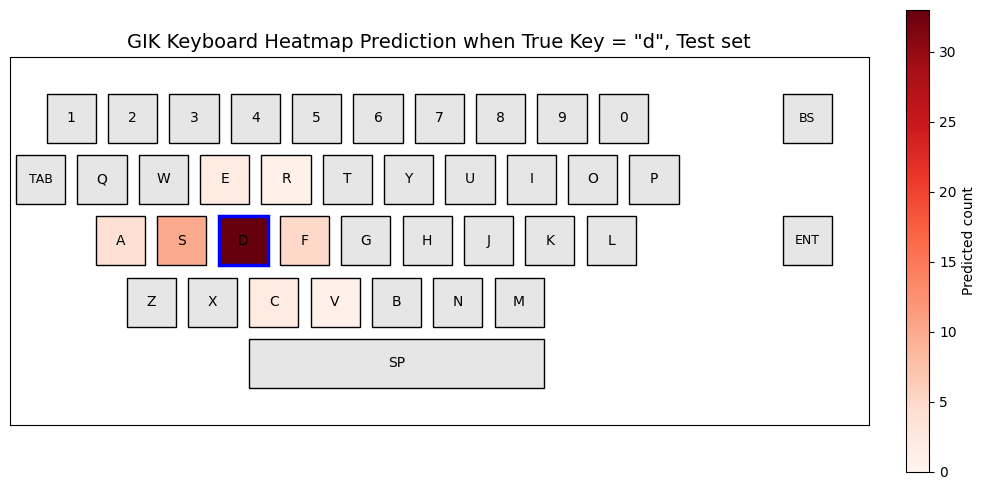

In [104]:
coord_dict = FULL_COORDS if CONFIG["regression"] else None
cm_orig = compute_confusion_matrix_40x40(trainer.test_dataset, model, DEVICE, coord_dict=coord_dict)

plot_virtual_keyboard_heatmap(cm_orig, 'd', 'Test')

# Optional matrix view
# plot_confusion_matrix_40x40(cm_orig, 'Test')

# neighbours_a, cm_a = plot_anchor_with_closest_neighbours(cm_orig, 'i', 'Test', k_neighbours=5)
# neighbours_g, cm_g = plot_anchor_with_closest_neighbours(cm_orig, 'l', 'Test', k_neighbours=5)
# neighbours_l, cm_l = plot_anchor_with_closest_neighbours(cm_orig, 'l', 'Test', k_neighbours=13)

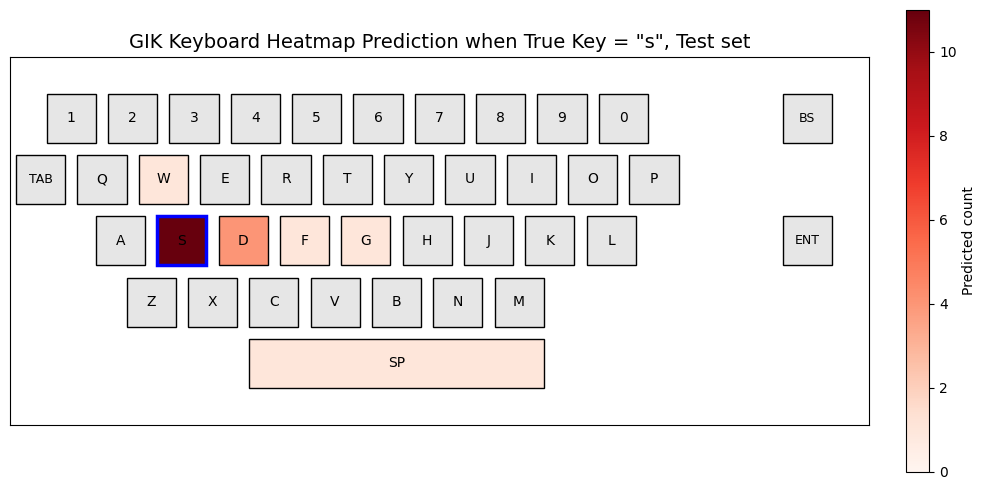

In [105]:
plot_virtual_keyboard_heatmap(cm_orig, 's', 'Test')

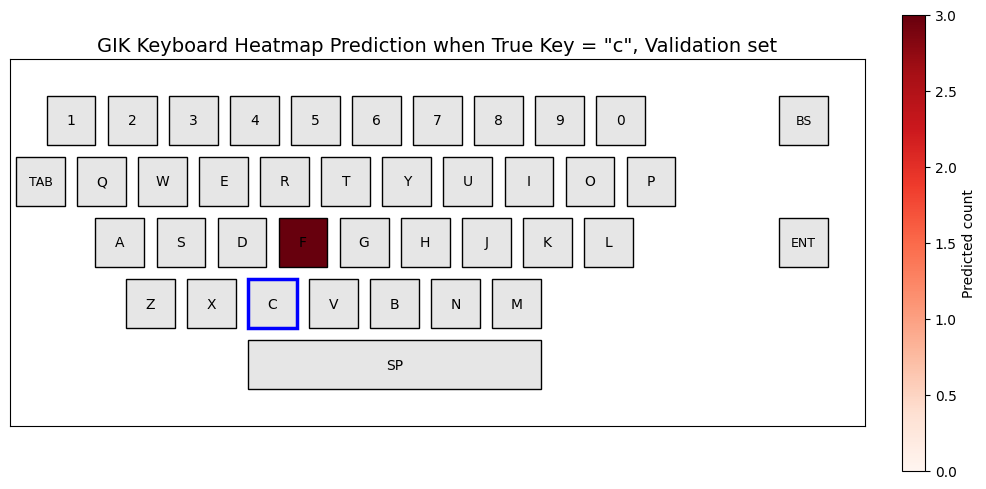

In [111]:
cm_orig_val = compute_confusion_matrix_40x40(
    trainer.val_dataset,
    model,
    DEVICE,
    coord_dict=FULL_COORDS if CONFIG["regression"] else None,
)

plot_virtual_keyboard_heatmap(cm_orig_val, 'c', 'Validation')

# Optional matrix view
# plot_confusion_matrix_40x40(cm_orig_val, 'Validation')

# neighbours_a_val, cm_a_val = plot_anchor_with_closest_neighbours(cm_orig_val, 'd', 'Validation', k_neighbours=12)
# neighbours_g_val, cm_g_val = plot_anchor_with_closest_neighbours(cm_orig_val, 'g', 'Validation', k_neighbours=20)
# neighbours_l_val, cm_l_val = plot_anchor_with_closest_neighbours(cm_orig_val, 'l', 'Validation', k_neighbours=13)

## Save Model

In [107]:
# MODEL_PATH = os.path.join(DATA_DIR, "gik_model.pt")
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'config': CONFIG,
#     'input_dim': dataset.input_dim,
#     'metadata': metadata
# }, MODEL_PATH)
# print(f"Model saved to {MODEL_PATH}")